In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import pytz

In [14]:
def allprint(df):
    """
    pandas DataFrame의 모든 행과 모든 열을 제한 없이 출력하는 함수.
    사용 후 원래 display 설정을 복원함.
    """
    # 현재 설정값 백업
    old_max_rows = pd.get_option('display.max_rows')
    old_max_cols = pd.get_option('display.max_columns')
    
    try:
        # 임시로 최대 행/열 출력 제한 해제
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        
        display(df)
    finally:
        # 함수 종료 후 원래 설정 복원
        pd.set_option('display.max_rows', old_max_rows)
        pd.set_option('display.max_columns', old_max_cols)


In [31]:
usd_krw_spot=pd.read_pickle('data/SMB(20240312-20250312).pkl')
usd_krw_spot.index= pd.to_datetime(usd_krw_spot.index)
usd_krw_spot


KRWE=KFTC,HIGH_1,LOW_1,OPEN_PRC,TRDPRC_1,NUM_MOVES,BID_HIGH_1,BID_LOW_1,OPEN_BID,BID,BID_NUMMOV,ASK_HIGH_1,ASK_LOW_1,OPEN_ASK,ASK,ASK_NUMMOV,MID_HIGH,MID_LOW,MID_OPEN,MID_PRICE
Timestamp,,,,,,,,,,,,,,,,,,,
2024-03-12 09:00:00,1312.0,1311.0,1311.0,1311.6,20,1311.8,1310.0,1310.0,1311.6,40,1313.0,1311.1,1313.0,1311.7,39,1311.9,1310.0,1310.0,1311.65
2024-03-12 09:01:00,1311.8,1310.7,1311.7,1310.8,82,1311.8,1310.7,1311.6,1310.8,68,1311.9,1310.8,1311.8,1311.0,68,1311.85,1310.75,1311.7,1310.9
2024-03-12 09:02:00,1311.0,1310.4,1311.0,1310.4,59,1311.0,1310.3,1310.8,1310.4,63,1311.1,1310.4,1311.1,1310.5,63,1311.05,1310.35,1310.95,1310.45
2024-03-12 09:03:00,1310.8,1310.3,1310.4,1310.7,49,1310.8,1310.2,1310.3,1310.6,47,1310.9,1310.3,1310.5,1310.7,47,1310.85,1310.25,1310.4,1310.65
2024-03-12 09:04:00,1310.6,1310.4,1310.6,1310.5,41,1310.5,1310.3,1310.5,1310.5,42,1310.7,1310.4,1310.7,1310.6,42,1310.6,1310.35,1310.6,1310.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12 00:53:00,<NA>,<NA>,<NA>,<NA>,<NA>,1453.3,1453.3,1453.3,1453.3,3,1455.6,1454.3,1455.6,1454.3,3,1454.45,1453.8,1454.45,1453.8
2025-03-12 00:54:00,<NA>,<NA>,<NA>,<NA>,<NA>,1453.3,1453.3,1453.3,1453.3,4,1455.6,1454.3,1455.6,1454.3,4,1454.45,1453.8,1454.45,1453.8
2025-03-12 00:55:00,<NA>,<NA>,<NA>,<NA>,<NA>,1453.3,1453.3,1453.3,1453.3,2,1454.2,1454.1,1454.2,1454.1,2,1453.75,1453.7,1453.75,1453.7


In [ ]:
url = "https://api.bithumb.com/v1/candles/minutes/1"
chunk_size = 200
overlap_minutes = 10  # 10분 겹침
start_date = datetime(2023, 12, 1)
end_date = datetime.now()
market= "KRW-USDT"

# 단일 요청 함수
def fetch_candlestick(market,to_time, count=chunk_size):
    params = {
        "market": market,
        "to": to_time.strftime("%Y-%m-%d %H:%M:%S"),
        "count": str(count)
    }
    try:
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"요청 실패 (시각: {to_time}, 상태 코드: {response.status_code})")
            return None
        data = response.json()
        if not isinstance(data, list) or len(data) == 0:
            print(f"데이터 없음 (시각: {to_time})")
            return None
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"에러 발생 (시각: {to_time}): {e}")
        return None

# 겹침 요청으로 전체 데이터 수집
def fetch_all_data():
    total_minutes = int((end_date - start_date).total_seconds() / 60)
    step_size = chunk_size - overlap_minutes  # 190분씩 이동
    num_requests = (total_minutes + step_size - 1) // step_size
    to_times = [end_date - timedelta(minutes=i * step_size) for i in range(num_requests)]
    
    all_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_time = {executor.submit(fetch_candlestick, market, to_time): to_time for to_time in to_times}
        for future in as_completed(future_to_time):
            to_time = future_to_time[future]
            result = future.result()
            if result is not None:
                all_data.append(result)
                last_time = pd.to_datetime(result['candle_date_time_kst']).min()
                print(f"가져옴: {to_time}, 캔들 수: {len(result)}, 첫 시각: {last_time}")
    
    if all_data:
        df = pd.concat(all_data).drop_duplicates(subset="candle_date_time_kst").sort_values("candle_date_time_kst")
        df = df[df['candle_date_time_kst'] >= start_date.strftime("%Y-%m-%d %H:%M:%S")]
        return df
    return pd.DataFrame()

# 벡터 연산으로 누락 체크
def check_missing_candles_vectorized(df):
    df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst'])
    df = df.sort_values('candle_date_time_kst').reset_index(drop=True)
    time_diffs = df['candle_date_time_kst'].diff().dt.total_seconds() / 60
    gaps = time_diffs > 1
    
    if not gaps.any():
        print("누락된 시간대 없음")
        return []
    
    gap_starts = df['candle_date_time_kst'].shift(1)[gaps] + timedelta(minutes=1)
    gap_ends = df['candle_date_time_kst'][gaps] - timedelta(minutes=1)
    gap_counts = (time_diffs[gaps] - 1).astype(int)
    missing_times = list(zip(gap_starts, gap_ends, gap_counts))
    
    print(f"총 {len(missing_times)}개의 누락된 시간대 발견")
    for start, end, count in missing_times[:5]:
        print(f"누락 구간: {start} ~ {end}, 누락된 캔들 수: {count}")
    if len(missing_times) > 5:
        print("...")
    total_missing = sum(count for _, _, count in missing_times)
    print(f"총 누락된 캔들 수: {total_missing}")
    return missing_times

# 누락된 캔들 API로 채우기
def fill_missing_from_api(df):
    missing_times = check_missing_candles_vectorized(df)
    if not missing_times:
        return df
    
    print("API로 누락된 데이터 채우기 시작")
    new_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_gap = {}
        for gap_start, gap_end, count in missing_times:
            to_time = gap_end
            future = executor.submit(fetch_candlestick, market, to_time, min(chunk_size, count + 1))
            future_to_gap[future] = (gap_start, gap_end)
        
        for future in as_completed(future_to_gap):
            gap_start, gap_end = future_to_gap[future]
            result = future.result()
            if result is not None:
                result['candle_date_time_kst'] = pd.to_datetime(result['candle_date_time_kst'])
                filtered = result[(result['candle_date_time_kst'] >= gap_start) & 
                                (result['candle_date_time_kst'] <= gap_end)]
                if not filtered.empty:
                    new_data.append(filtered)
                    print(f"채움: {gap_start} ~ {gap_end}, 캔들 수: {len(filtered)}")
    
    if new_data:
        new_df = pd.concat(new_data)
        full_df = pd.concat([df, new_df]).drop_duplicates(subset="candle_date_time_kst").sort_values("candle_date_time_kst")
        print(f"총 추가된 캔들 수: {len(new_df)}")
        return full_df
    return df

# 실행 및 최종 검증
def process_and_verify():
    print("초기 데이터 수집 시작")
    df = fetch_all_data()
    print(f"초기 데이터 크기: {len(df)}")
    
    print("\n초기 누락 체크:")
    filled_df = fill_missing_from_api(df)
    
    print("\n최종 누락 체크:")
    check_missing_candles_vectorized(filled_df)
    
    print(f"최종 데이터 크기: {len(filled_df)}")
    return filled_df

# 실행
final_df = process_and_verify()
final_df.set_index('candle_date_time_kst', inplace=True)
final_df.index= pd.to_datetime(final_df.index)
final_df.drop(['candle_date_time_utc','timestamp'], axis=1, inplace=True)
display(final_df)

초기 데이터 수집 시작
가져옴: 2025-04-21 11:23:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 08:04:00
가져옴: 2025-04-21 20:53:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 17:34:00
가져옴: 2025-04-21 14:33:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 11:14:00
가져옴: 2025-04-21 01:53:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 22:34:00
가져옴: 2025-04-20 16:23:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 13:04:00
가져옴: 2025-04-20 22:43:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 19:24:00
가져옴: 2025-04-21 17:43:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 14:24:00
가져옴: 2025-04-21 08:13:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 04:54:00
가져옴: 2025-04-21 05:03:37.903751, 캔들 수: 200, 첫 시각: 2025-04-21 01:44:00
가져옴: 2025-04-20 19:33:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 16:14:00
가져옴: 2025-04-20 13:13:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 09:54:00
가져옴: 2025-04-20 03:43:37.903751, 캔들 수: 200, 첫 시각: 2025-04-20 00:24:00
가져옴: 2025-04-19 18:13:37.903751, 캔들 수: 200, 첫 시각: 2025-04-19 14:54:00
가져옴: 2025-04-20 00:33:37.903751, 캔들 수: 200, 첫 시각: 2025-04-19 21:14:00
가져옴: 20

C:\Users\panda\AppData\Local\Temp/ipykernel_120052/1757299837.py:98: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result['candle_date_time_kst'] = pd.to_datetime(result['candle_date_time_kst'])


요청 실패 (시각: 2024-02-10 22:38:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-11 01:07:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-12 05:05:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-12 05:44:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-12 05:37:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-12 05:33:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-14 16:03:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-14 11:58:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-14 23:58:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 02:38:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 00:45:00, 상태 코드: 429)요청 실패 (시각: 2024-02-14 13:37:00, 상태 코드: 429)

요청 실패 (시각: 2024-02-15 03:16:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 02:45:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 03:46:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 03:36:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 03:53:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 04:10:00, 상태 코드: 429)
요청 실패 (시각: 2024-02-15 04:06:00, 상태 코드: 429)

최종 누락 체크:
총 4526개의 누락된 시간대 발견
누락 구간: 2023-12-07 17:42:00 ~ 2023-12-07 17:42:00, 누락된 캔들 수: 1
누락 구간: 2023-12-07 23:22:00 ~ 2023-12-07 23:22:00, 누락된 캔들 수: 1
누락 구간: 20

,market,opening_price,high_price,low_price,trade_price,candle_acc_trade_price,candle_acc_trade_volume,unit
candle_date_time_kst,,,,,,,,
2023-12-07 12:05:00,KRW-USDT,1186,1387,1186,1384,2.749764e+09,1.984810e+06,1
2023-12-07 12:06:00,KRW-USDT,1384,1384,1383,1384,5.064263e+08,3.659658e+05,1
2023-12-07 12:07:00,KRW-USDT,1384,1384,1383,1384,2.813397e+08,2.033706e+05,1
2023-12-07 12:08:00,KRW-USDT,1383,1384,1383,1383,5.702995e+08,4.122609e+05,1
2023-12-07 12:09:00,KRW-USDT,1384,1384,1383,1384,3.714070e+08,2.685249e+05,1
...,...,...,...,...,...,...,...,...
2025-04-21 20:49:00,KRW-USDT,1433,1434,1433,1433,2.655693e+07,1.852316e+04,1
2025-04-21 20:50:00,KRW-USDT,1434,1434,1433,1433,2.808222e+07,1.958702e+04,1
2025-04-21 20:51:00,KRW-USDT,1433,1434,1433,1433,7.833378e+07,5.462868e+04,1


In [145]:
usdt_krw_OHLC=final_df[['opening_price','high_price','low_price','trade_price']]
usdt_krw_OHLC.columns=['open','high','low','close']
raw_data=pd.concat([usdt_krw_OHLC,usd_krw_spot['MID_PRICE']], axis=1).sort_index()
raw_data

kst_tz = pytz.timezone('Asia/Seoul')
dt_kst = raw_data.index.tz_localize(kst_tz)
raw_data.index= dt_kst
raw_data

,open,high,low,close,MID_PRICE
2023-12-07 12:05:00+09:00,1186.0,1387.0,1186.0,1384.0,<NA>
2023-12-07 12:06:00+09:00,1384.0,1384.0,1383.0,1384.0,<NA>
2023-12-07 12:07:00+09:00,1384.0,1384.0,1383.0,1384.0,<NA>
2023-12-07 12:08:00+09:00,1383.0,1384.0,1383.0,1383.0,<NA>
2023-12-07 12:09:00+09:00,1384.0,1384.0,1383.0,1384.0,<NA>
...,...,...,...,...,...
2025-04-21 20:49:00+09:00,1433.0,1434.0,1433.0,1433.0,<NA>
2025-04-21 20:50:00+09:00,1434.0,1434.0,1433.0,1433.0,<NA>
2025-04-21 20:51:00+09:00,1433.0,1434.0,1433.0,1433.0,<NA>
2025-04-21 20:52:00+09:00,1433.0,1434.0,1433.0,1434.0,<NA>


In [146]:
# CSV 파일 읽기
df_recent = pd.read_csv('data/usd_spot_20250421_2153.csv')
df_recent.columns = ['Date', 'Time', 'Price']

# 오전/오후를 AM/PM으로 변환
df_recent['Time'] = df_recent['Time'].str.replace('오전', 'AM').str.replace('오후', 'PM')

# Date와 Time 결합
datetime_str = df_recent['Date'] + ' ' + df_recent['Time']

# datetime 객체로 변환 (EDT 기준)
dt_edt = pd.to_datetime(datetime_str, format='%d-%b-%y %p %I:%M:%S')

# EDT 타임존 설정
edt_tz = pytz.timezone('America/New_York')
dt_edt = dt_edt.dt.tz_localize(edt_tz)

# KST로 변환
kst_tz = pytz.timezone('Asia/Seoul')
dt_kst = dt_edt.dt.tz_convert(kst_tz)

df_recent.index= pd.to_datetime(dt_kst)
df_recent.sort_index(inplace=True)
df_recent

,Date,Time,Price
2025-02-21 21:00:00+09:00,21-Feb-25,AM 7:00:00,1432.980
2025-02-21 21:01:00+09:00,21-Feb-25,AM 7:01:00,1432.990
2025-02-21 21:02:00+09:00,21-Feb-25,AM 7:02:00,1433.290
2025-02-21 21:03:00+09:00,21-Feb-25,AM 7:03:00,1433.080
2025-02-21 21:04:00+09:00,21-Feb-25,AM 7:04:00,1433.010
...,...,...,...
2025-04-21 21:44:00+09:00,21-Apr-25,AM 8:44:00,1418.080
2025-04-21 21:45:00+09:00,21-Apr-25,AM 8:45:00,1418.060
2025-04-21 21:46:00+09:00,21-Apr-25,AM 8:46:00,1418.070
2025-04-21 21:47:00+09:00,21-Apr-25,AM 8:47:00,1418.000


In [147]:
mid_price=raw_data['MID_PRICE'].copy()
mid_price_NA=mid_price[(pd.isna(mid_price))]
NA_date_index=raw_data.index.intersection(df_recent.index).intersection(mid_price_NA.index)
mid_price[NA_date_index]=df_recent['Price'][NA_date_index]
mid_price

2023-12-07 12:05:00+09:00       <NA>
2023-12-07 12:06:00+09:00       <NA>
2023-12-07 12:07:00+09:00       <NA>
2023-12-07 12:08:00+09:00       <NA>
2023-12-07 12:09:00+09:00       <NA>
                              ...   
2025-04-21 20:49:00+09:00    1419.74
2025-04-21 20:50:00+09:00    1419.74
2025-04-21 20:51:00+09:00    1419.72
2025-04-21 20:52:00+09:00    1419.73
2025-04-21 20:53:00+09:00    1419.74
Name: MID_PRICE, Length: 714121, dtype: Float64

In [157]:
raw_data['MID_PRICE']=mid_price
raw_data.ffill(inplace=True)
raw_data=raw_data.dropna()
raw_data['K_prem(%)']=(raw_data['close']/raw_data['MID_PRICE']-1)*100

# set regime
regime=pd.Series(np.zeros(len(raw_data)),index=raw_data.index)
regime[raw_data['K_prem(%)']<-2.5]=-4
regime[(raw_data['K_prem(%)']>=-2.5) & (raw_data['K_prem(%)']<-1.5)]=-3
regime[(raw_data['K_prem(%)']>=-1.5) & (raw_data['K_prem(%)']<-0.5)]=-2
regime[(raw_data['K_prem(%)']>=-0.5) & (raw_data['K_prem(%)']<0)]=-1
regime[(raw_data['K_prem(%)']>=0) & (raw_data['K_prem(%)']<0.5)]=0
regime[(raw_data['K_prem(%)']>=0.5) & (raw_data['K_prem(%)']<1.5)]=1
regime[(raw_data['K_prem(%)']>=1.5) & (raw_data['K_prem(%)']<2.5)]=2 #유학생 아비트라지권
regime[(raw_data['K_prem(%)']>=2.5) & (raw_data['K_prem(%)']<3.5)]=3 # 카드 아비트라지권
regime[(raw_data['K_prem(%)']>=3.5) & (raw_data['K_prem(%)']<4.5)]=4 # 카드 아비트라지 수익권
regime[(raw_data['K_prem(%)']>=4.5) & (raw_data['K_prem(%)']<5.5)]=5 # 누구든 아비트라지 수익권
regime[(raw_data['K_prem(%)']>=5.5)]=6  # 초과열 
regime=regime.astype(int)
raw_data['regime']=regime

C:\Users\panda\AppData\Local\Temp/ipykernel_120052/2851006413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['MID_PRICE']=mid_price
C:\Users\panda\AppData\Local\Temp/ipykernel_120052/2851006413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data.ffill(inplace=True)


In [159]:
raw_data['K_prem(%)'].rolling(60).mean()



2024-03-12 09:00:00+09:00         NaN
2024-03-12 09:01:00+09:00         NaN
2024-03-12 09:02:00+09:00         NaN
2024-03-12 09:03:00+09:00         NaN
2024-03-12 09:04:00+09:00         NaN
                               ...   
2025-04-21 20:49:00+09:00    0.981562
2025-04-21 20:50:00+09:00    0.981011
2025-04-21 20:51:00+09:00    0.980282
2025-04-21 20:52:00+09:00    0.980727
2025-04-21 20:53:00+09:00    0.980407
Name: K_prem(%), Length: 579093, dtype: float64

In [161]:
raw_data['K_prem(%)'].rolling(60).std()

2024-03-12 09:00:00+09:00         NaN
2024-03-12 09:01:00+09:00         NaN
2024-03-12 09:02:00+09:00         NaN
2024-03-12 09:03:00+09:00         NaN
2024-03-12 09:04:00+09:00         NaN
                               ...   
2025-04-21 20:49:00+09:00    0.064256
2025-04-21 20:50:00+09:00    0.064524
2025-04-21 20:51:00+09:00    0.064792
2025-04-21 20:52:00+09:00    0.064871
2025-04-21 20:53:00+09:00    0.065056
Name: K_prem(%), Length: 579093, dtype: float64

<Axes: title={'center': 'K_prem'}>

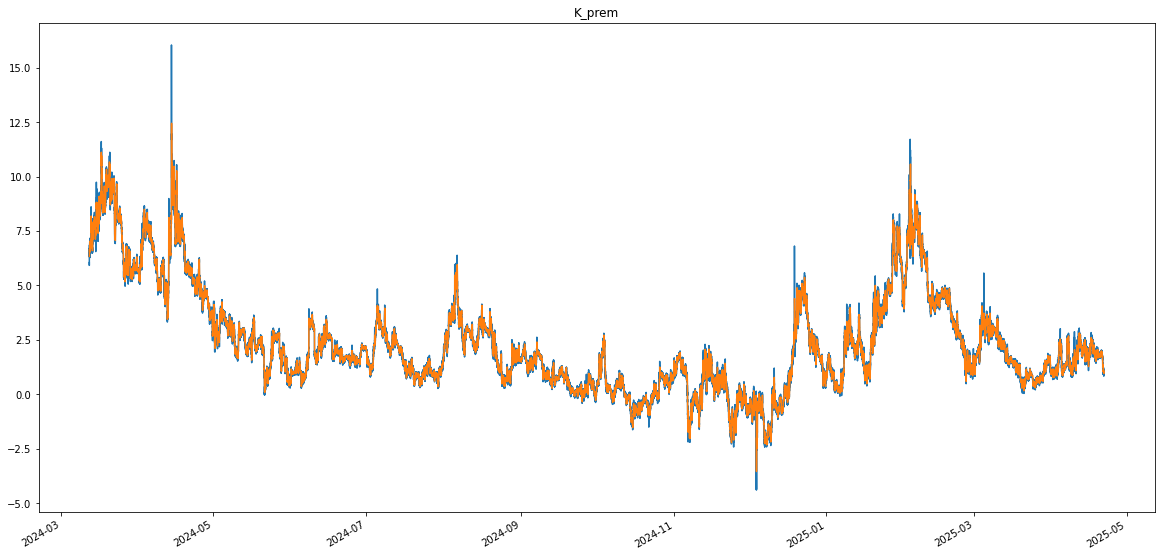

In [156]:
raw_data['K_prem(%)'].plot(figsize=(20,10),title='K_prem')
raw_data['K_prem(%)'].rolling(60).mean().plot()